# Algo trading project


In [ ]:
!pip3 install alpaca-trade-api

## Initialization

In [ ]:
from alpaca.data.timeframe import TimeFrame
from alpaca.data.requests import StockBarsRequest
from alpaca.data.historical import StockHistoricalDataClient# Create stock historical data client
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# Set API key and secret
api_key = 'your_api_key'
api_secret = 'your_api_secret'

# Initialize trading client for live trading (using paper trading mode)
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest, StopLossOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from time import sleep

trading_client = TradingClient(api_key, api_secret, paper=True)

## Load historical data

In [25]:
# # Load historical data for backtesting
# client = StockHistoricalDataClient(api_key, api_secret)
# request_params = StockBarsRequest(
#     symbol_or_symbols=["TSLA"],
#     timeframe=TimeFrame.Day,
#     start="2015-01-01 00:00:00",
#     end="2023-06-01 00:00:00"
# )
# historical_data = client.get_stock_bars(request_params).df
# print(historical_data.tail())
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import yfinance as yf
import pandas as pd

symbol = "TSLA"
start_date = "2016-01-01"
end_date = "2024-01-01"
timeframe = "1d"

historical_data = yf.download(symbol, start=start_date, end=end_date, interval=timeframe)
historical_data.columns

[*********************100%***********************]  1 of 1 completed


MultiIndex([('Adj Close', 'TSLA'),
            (    'Close', 'TSLA'),
            (     'High', 'TSLA'),
            (      'Low', 'TSLA'),
            (     'Open', 'TSLA'),
            (   'Volume', 'TSLA')],
           names=['Price', 'Ticker'])

## Define strategy and backtesting methods

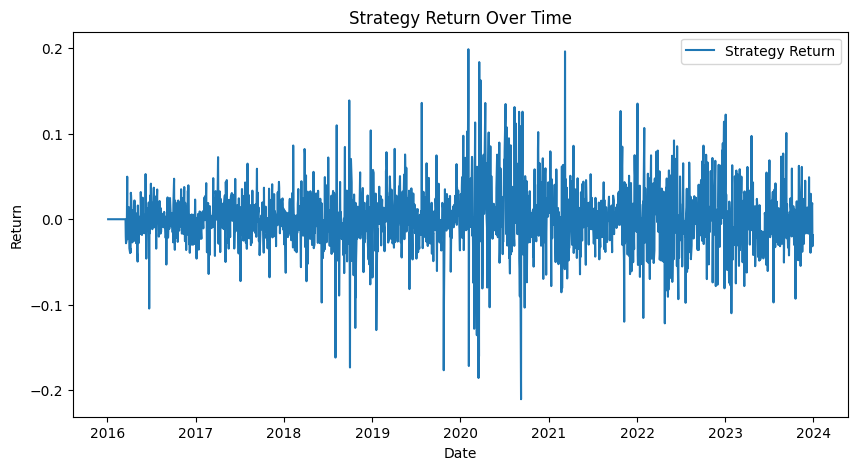

In [68]:
def moving_average_strategy(data, short_window, long_window):
    # Calculate moving averages
    data['short_mavg'] = data['Close', 'TSLA'].rolling(window=short_window, min_periods=1, center=False).mean()
    data['long_mavg'] = data['Close', 'TSLA'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Create trading signals (1 for buy, -1 for sell, 0 for hold)
    data['signal'] = np.where(data['short_mavg'] > data['long_mavg'], 1.0, 0.0)
    data['signal'] = np.where(data['short_mavg'] < data['long_mavg'], -1.0, data['signal'])

    # Ensure the result is a Series by selecting the appropriate column if needed
    # If 'signal' or 'Close' are DataFrames, select the relevant column for calculation
    signal_column = data['signal'] if isinstance(data['signal'], pd.Series) else data['signal'].iloc[:, 0]
    close_column = data['Close'] if isinstance(data['Close'], pd.Series) else data['Close'].iloc[:, 0]

    data['strategy_return'] = (signal_column.shift(1) * close_column.pct_change()).fillna(0)

    return data

aug_data = moving_average_strategy(historical_data, 50, 200)['strategy_return']
plt.figure(figsize=(10, 5))
plt.plot(aug_data.index, aug_data, label='Strategy Return')
plt.title('Strategy Return Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

In [58]:
def monte_carlo_simulation(data, short_window, long_window, num_simulations=1000):
    simulation_results = []

    for _ in range(num_simulations):
        simulated_data = data.copy()
        simulated_data['Close', 'TSLA'] *= (1 + np.random.normal(0, 0.01, len(simulated_data)))  # Add random noise

        strategy_simulated = moving_average_strategy(simulated_data, short_window, long_window)
        strategy_returns = strategy_simulated['strategy_return'].dropna()

        # cumulative return and max drawdown
        cumulative_return = (1 + strategy_returns).prod() - 1
        max_drawdown = calculate_max_drawdown(strategy_returns)

        simulation_results.append((cumulative_return, max_drawdown))

    return simulation_results

In [55]:
def calculate_sharpe_ratio(strategy_returns, risk_free_rate=0.02):
    excess_returns = strategy_returns.mean() - risk_free_rate / 252  # Adjust for daily returns
    std_dev = strategy_returns.std()

    if std_dev == 0:
        print("Warning: Standard deviation of strategy returns is zero. Setting Sharpe ratio to 0.")
        return 0

    return excess_returns / std_dev


def calculate_max_drawdown(strategy_returns):
    cumulative_returns = (1 + strategy_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

In [61]:
def walk_forward_testing(data, short_window_range, long_window_range, train_period, test_period):
    best_param = None
    best_score = -np.inf

    for start in range(0, len(data) - train_period - test_period + 1, test_period):
        train_data = data[start:start + train_period]
        test_data = data[start + train_period:start + train_period + test_period]

        best_sharpe = -np.inf
        best_long_window = None
        best_short_window = None

        # Optimize parameters on training data
        for short_window in short_window_range:
            for long_window in long_window_range:
                strategy_train = moving_average_strategy(train_data.copy(), short_window, long_window)
                strategy_returns = strategy_train['strategy_return'].dropna()

                # Check if strategy_returns is empty before calculating Sharpe ratio
                if not strategy_returns.empty:
                    sharpe_train = calculate_sharpe_ratio(strategy_returns)

                    if sharpe_train > best_sharpe:
                        best_sharpe = sharpe_train
                        best_short_window = short_window
                        best_long_window = long_window
                else:
                    # Handle case where strategy_returns is empty
                    print(f"Warning: Empty strategy returns for short_window={short_window}, long_window={long_window}. Skipping...")
                    continue

        # Ensure best parameters are set before using them
        if best_short_window is None or best_long_window is None:
            print("Error: No suitable parameters found during optimization.")
            return None, None # Or raise an exception

        # use the best parameters to evaluate on the test data
        strategy_test = moving_average_strategy(test_data.copy(), best_short_window, best_long_window)
        test_returns = strategy_test['strategy_return'].dropna()

        # performance metrics for the test data
        sharpe_test = calculate_sharpe_ratio(test_returns)
        # max_drawdown_test = calculate_max_drawdown(test_returns)
        # monte_carlo_results = monte_carlo_simulation(test_data, best_short_window, best_long_window)
        # avg_cumulative_return = np.mean([result[0] for result in monte_carlo_results])
        # avg_max_drawdown = np.mean([result[1] for result in monte_carlo_results])

        # *****CHOOSE METRIC {sharp_test, max_drawdown_test, avg_cumulative_return, avg_max_drawdown}*****
        score = sharpe_test

        # Update best parameters
        if score > best_score:
            best_score = score
            best_param = (best_short_window, best_long_window)

    return best_param, best_score

## Backtest the strategy

In [63]:
train_period = 500
test_period = 100
short_window_range = range(10, 100, 10)
long_window_range = range(100, 300, 10)

best_parameters, best_sharp = walk_forward_testing(historical_data, short_window_range, long_window_range, train_period, test_period)

# Output the best parameters for future prediction
print(f'best short window = {best_parameters[0]}, best long window = {best_parameters[1]}, best sharp ratio = {best_sharp}')

best short window = 90, best long window = 160, best sharp ratio = 0.20171600738685616


# Live paper trading

In [ ]:
# Define parameters
symbol = "TSLA"
short_window = 50
long_window = 200
buy_qty = 10

# Initialize performance tracking
trade_log = []
total_profit = 0
total_trades = 0

def log_trade(order, trade_type, price):
    global total_profit, total_trades
    if trade_type == 'buy':
        trade_log.append({
            'type': 'buy',
            'price': price,
            'timestamp': pd.Timestamp.now()
        })
    elif trade_type == 'sell':
        last_trade = next((t for t in reversed(trade_log) if t['type'] == 'buy'), None)
        if last_trade:
            profit = price - last_trade['price']
            total_profit += profit
            total_trades += 1
            trade_log.append({
                'type': 'sell',
                'price': price,
                'timestamp': pd.Timestamp.now(),
                'profit': profit
            })
            print(f"Trade executed: Buy at {last_trade['price']}, Sell at {price}, Profit: {profit}")

def get_moving_averages():
    request_params = StockBarsRequest(
        symbol_or_symbols=[symbol],
        timeframe=TimeFrame.Day,
        start="2023-01-01 00:00:00"
    )
    historical_data = client.get_stock_bars(request_params).df
    historical_data['short_ma'] = historical_data['close'].rolling(window=short_window).mean()
    historical_data['long_ma'] = historical_data['close'].rolling(window=long_window).mean()
    return historical_data

In [ ]:
def execute_trade():
    historical_data_live = get_moving_averages()
    last_row = historical_data_live.iloc[-1]
    previous_row = historical_data_live.iloc[-2]

    if last_row['short_ma'] > last_row['long_ma'] and previous_row['short_ma'] <= previous_row['long_ma']:
        # Place a market buy order
        market_order_data = MarketOrderRequest(
            symbol=symbol,
            qty=buy_qty,
            side=OrderSide.BUY,
            time_in_force=TimeInForce.GTC,
        )
        market_order = trading_client.submit_order(order_data=market_order_data)
        buy_price = float(market_order.filled_avg_price)
        print(f"Market buy order placed at {buy_price}")
        log_trade(market_order, 'buy', buy_price)

        # Set a stop-loss 5% below the buy price
        stop_loss_price = buy_price * 0.95
        stop_loss_order_data = StopLossOrderRequest(
            symbol=symbol,
            qty=buy_qty,
            side=OrderSide.SELL,
            stop_price=stop_loss_price,
            time_in_force=TimeInForce.GTC
        )
        trading_client.submit_order(order_data=stop_loss_order_data)
        print(f"Stop-loss order placed at {stop_loss_price}")

    elif last_row['short_ma'] < last_row['long_ma'] and previous_row['short_ma'] >= previous_row['long_ma']:
        # Place a market sell order (if in position)
        market_order_data = MarketOrderRequest(
            symbol=symbol,
            qty=buy_qty,
            side=OrderSide.SELL,
            time_in_force=TimeInForce.GTC,
        )
        market_order = trading_client.submit_order(order_data=market_order_data)
        sell_price = float(market_order.filled_avg_price)
        print(f"Market sell order placed at {sell_price}")
        log_trade(market_order, 'sell', sell_price)

In [ ]:
# Monitor live price updates and adjust positions
while True:
    try:
        execute_trade()
        # Print performance metrics
        print(f"Total Trades: {total_trades}, Total Profit: {total_profit}")
        sleep(60)  # Wait 1 minute before the next iteration
    except Exception as e:
        print(f"An error occurred: {e}")